In [1]:
import os
import json
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from matplotlib import rcParams

import src as sp
import runtime as rt
from theme import colors

# font parameters
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 12

In [2]:
# reproducibility
#np.random.seed(0)
#pt.manual_seed(0)

In [3]:
# parameters
device = pt.device("cuda")

# model parameters
# r6
save_path = "model/save/s_v6_4_2022-09-16_11-51"  # virtual Cb & partial
#save_path = "model/save/s_v6_5_2022-09-16_11-52"  # virtual Cb, partial & noise

# r7
#save_path = "model/save/s_v7_0_2023-04-25"  # partial chain
#save_path = "model/save/s_v7_1_2023-04-25"  # partial secondary structure
#save_path = "model/save/s_v7_2_2023-04-25"  # partial chain high coverage

# create models
model = rt.SequenceModel(save_path, "model.pt", device=device)

# create confidence mapping
conf = rt.ConfidenceMap("results/{}_cdf.csv".format(os.path.basename(save_path)))

In [4]:
# parameters
#structure = rt.load_structure("pymol/1zns_ref_dna.pdb")
structure = rt.load_structure("pymol/1zns_2ivh_dna.pdb")
structure['chain_name'] = np.array([str(cid) for cid in structure['cid']])

In [5]:
def scoring(p, y):
    # compute confidence probability
    c = pt.from_numpy(conf(p.numpy()))

    # get sequence
    seq_ref = rt.max_pred_to_seq(y)
    seq = rt.max_pred_to_seq(c)

    # assess predictions
    return {
        "size": p.shape[0],
        "recovery_rate": rt.recovery_rate(y, c).numpy().item(),
        "sequence_similarity": rt.sequence_similarity(seq_ref, seq),
        "maximum_recovery_rate": rt.maximum_recovery_rate(y, p).numpy().item(),
        "average_multiplicity": rt.average_multiplicity(p).numpy().item(),
        "average_maximum_confidence": rt.average_maximum_confidence(p).numpy().item(),
        "average_maximum_score": rt.average_maximum_confidence(c).numpy().item(),
    }

In [6]:
# parameters
d_thr = 4.0  # dna

# molecule type and discard unclassified
subunits = sp.split_by_chain(structure)
sub_types = rt.subunits_type(subunits)
subunits = {cid:subunits[cid] for cid in [st[1] for st in sub_types if st[0] != 'na']}
#subunits = {cid:subunits[cid] for cid in [st[1] for st in sub_types if st[0] != 'ligand']}
structure = sp.concatenate_chains(subunits)

# find proteins subunits and residue to chain mapping
cids_prot = [st[1] for st in sub_types if st[0] == 'protein']

# apply model on full structure
_, p, y = model(structure)

# prediction split by chain
rcids = np.array([res['chain_name'][0] for res in sp.split_by_residue(structure)])
pr = {cid:p[rcids==cid] for cid in cids_prot}
yr = {cid:y[rcids==cid] for cid in cids_prot}

# apply model with binder subunits known
pc, yc = {}, {}
for cid in cids_prot:
    m_known = (structure['chain_name'] != cid)
    _, pi, yi = model(structure, m_known=m_known)
    pi = pi[rcids==cid]
    yi = yi[rcids==cid]
    pi, yi = rt.aa_only(pi, yi)
    pc[cid] = pi
    yc[cid] = yi

# apply model to subunits alone
cids_prot = [st[1] for st in sub_types if st[0] == 'protein']
ps, ys = {}, {}
for cid in cids_prot:
    subunit = subunits[cid]
    subunit['chain_name'] = np.array([cid]*subunit['xyz'].shape[0])
    if len(np.unique(subunit['resid'])) >= model.module.config_data['min_num_res']:
        _, pi, yi = model(subunit)
        pi, yi = rt.aa_only(pi, yi)
        ps[cid] = pi
        ys[cid] = yi
        
# check that labels match perfectly
for cid in ys:
    assert pt.sum(pt.abs(yc[cid] - ys[cid])).long().item() == 0

# contacts
#contacts = sp.extract_all_contacts(subunits, d_thr, device=device)
contacts = {'0':{
    '3':pt.tensor([386, 385, 386, 386, 310, 310, 311, 312, 310, 310, 345, 346, 345, 377,
                   309, 310, 311, 309, 696, 697, 700, 696, 693, 694, 696, 697, 700, 701,
                   689, 711, 711, 714, 711, 714, 691, 714, 714, 957, 960, 960, 957, 958,
                   959, 960, 960]),
    '2':pt.tensor([949, 947, 949, 950, 949, 950, 713, 714, 915, 916, 950, 752, 758, 759,
                   761, 762, 763, 765, 767, 915, 916, 949, 950, 752, 915, 916, 752, 915,
                   744, 749, 364, 368, 749, 364, 741, 742, 744, 749, 750, 753, 754, 364,
                   366, 368, 364, 368, 744, 745, 728, 728, 366, 368, 338, 368, 368, 616,
                   620, 728, 576, 577, 578, 616, 619, 620, 727, 728, 608, 609, 616, 617,
                   620, 367, 367, 337, 615, 615, 613, 614, 615]),
    '1':pt.tensor([758, 761, 762, 763, 764, 765, 766, 767, 914, 915, 916, 948, 949, 950]),
}}

# analyse interface recovery
results = []
interfaces = {}
for cid in cids_prot:
    # checks
    if (cid in contacts) and (cid in ys):
        for cidb in sorted(list(contacts[cid])):
            # atom-atom contacts indices
            ctc_ids = contacts[cid][cidb]

            # convert to residue-residue contacts indices
            _, ids = pt.unique(pt.from_numpy(subunits[cid]['resid']), return_inverse=True)
            ctc_rids = pt.unique(ids[ctc_ids])

            ids_rctc = np.argmax((subunits[cid]['resid'].reshape(-1,1) == np.unique(subunits[cid]['resid'][np.unique(ctc_ids)])).astype(float), axis=0)
            rctc_seq = np.array([sp.res3to1[rn] for rn in subunits[cid]['resname'][ids_rctc]])
            
            # binder type
            btype = [st[0] for st in sub_types if st[1] == cidb][0]

            # scoring with context
            results.append({'context_level': 2, 'chain_id_scafold': cid,  'chain_id_binder': cidb, 'num_subunits': len(cids_prot), 'binder_type': btype})
            results[-1].update(scoring(pc[cid][ctc_rids], yc[cid][ctc_rids]))
            
            # scoring with context
            results.append({'context_level': 1, 'chain_id_scafold': cid,  'chain_id_binder': cidb, 'num_subunits': len(cids_prot), 'binder_type': btype})
            results[-1].update(scoring(pr[cid][ctc_rids], yr[cid][ctc_rids]))
            
            # scoring without context
            results.append({'context_level': 0, 'chain_id_scafold': cid,  'chain_id_binder': cidb, 'num_subunits': len(cids_prot), 'binder_type': btype})
            results[-1].update(scoring(ps[cid][ctc_rids], ys[cid][ctc_rids]))

            y0 = pt.max(ps[cid][ctc_rids] * ys[cid][ctc_rids], dim=1)[0].numpy()
            y1 = pt.max(pr[cid][ctc_rids] * yr[cid][ctc_rids], dim=1)[0].numpy()
            p0 = pt.max(ps[cid][ctc_rids], dim=1)[0].numpy()
            p1 = pt.max(pr[cid][ctc_rids], dim=1)[0].numpy()
            c0 = pt.max(pt.from_numpy(conf(ps[cid][ctc_rids].numpy())) * ys[cid][ctc_rids], dim=1)[0].numpy()
            c1 = pt.max(pt.from_numpy(conf(pr[cid][ctc_rids].numpy())) * yr[cid][ctc_rids], dim=1)[0].numpy()

            x = np.arange(y0.shape[0])
            if btype in interfaces:
                interfaces[btype][0] = np.concatenate([interfaces[btype][0], ctc_rids])
                interfaces[btype][1] = np.concatenate([interfaces[btype][1], y0])
                interfaces[btype][2] = np.concatenate([interfaces[btype][2], y1])
                interfaces[btype][3] = np.concatenate([interfaces[btype][3], p0])
                interfaces[btype][4] = np.concatenate([interfaces[btype][4], p1])
                interfaces[btype][5] = np.concatenate([interfaces[btype][5], c0])
                interfaces[btype][6] = np.concatenate([interfaces[btype][6], c1])
                interfaces[btype][7] = np.concatenate([interfaces[btype][7], rctc_seq])
            else:
                interfaces[btype] = [ctc_rids.numpy(), y0, y1, p0, p1, c0, c1, rctc_seq]

In [7]:
list(interfaces)

['ion', 'dna']

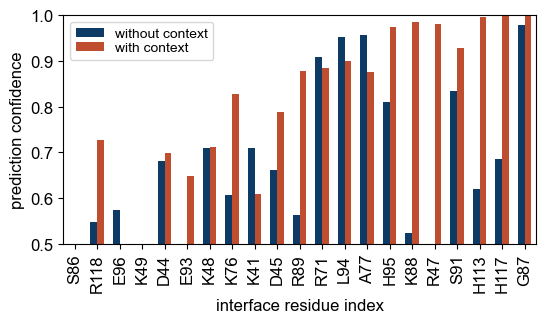

{'recovery_rate_without_context': 0.2857142857142857,
 'recovery_rate_with_context': 0.38095238095238093,
 'maximum_recovery_rate_without_context': 0.8095238095238095,
 'maximum_recovery_rate_with_context': 0.8571428571428571}

In [9]:
# parameters
ws = 0.3
itype = "dna"

# extract data
v, y0, y1, p0, p1, c0, c1, rn = interfaces[itype]
d0 = p0 - y0

# remove duplicated
idx = np.sort(np.unique(v, return_index=True)[1])
v = v[idx]
rn = rn[idx]
y0 = y0[idx]
y1 = y1[idx]
p0 = p0[idx]
p1 = p1[idx]

# sort predictions
#ids = np.argsort(np.maximum(y0, y1))
ids = np.array([17, 20, 10, 16,  0,  7, 15,  3, 13, 14,  5,  2,  8,  4,  9, 19,  1, 6, 11, 12, 18])
v = v[ids]
rn = rn[ids]
y0 = y0[ids]
y1 = y1[ids]
p0 = p0[ids]
p1 = p1[ids]
x = np.arange(v.shape[0])

# plot
plt.figure(figsize=(1+0.22*v.shape[0],3.4))
plt.bar(x-0.5*ws, y0, width=ws, color=colors[1], label="without context")
plt.bar(x+0.5*ws, y1, width=ws, color=colors[0], label="with context")
plt.xticks(x, [n+str(i) for n,i in zip(rn,v+1)], fontsize=12, weight='normal', rotation=90)
plt.yticks(np.linspace(0.5, 1.0, 6), np.linspace(0.5, 1.0, 6))
plt.xlim(-0.5, len(x)-0.5)
plt.ylim(0.5, 1.0)
plt.legend(loc='best', prop={'size': 10}, labelspacing=0.1)
plt.xlabel('interface residue index')
plt.ylabel('prediction confidence')
plt.tight_layout()
plt.savefig("graphs/1zns_2ivh_dna_interface_prediction.svg")
plt.show()

# save statistics
summary = {
    'recovery_rate_without_context': np.mean(p0.round(3) == y0.round(3)),
    'recovery_rate_with_context': np.mean(p1 == y1),
    'maximum_recovery_rate_without_context': np.mean(y0 >= 0.5),
    'maximum_recovery_rate_with_context': np.mean(y1 >= 0.5),
}
summary